In [1]:
import pandas as pd
import json
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path
import os


In [32]:
BASE_DIR = Path(os.getcwd()).resolve()
PAS_detailed_path = os.path.join(BASE_DIR, 'data\PAS_detailed2_fixed_borough.pkl')

In [33]:
PAS_detailed = pd.read_pickle(PAS_detailed_path)

The following part is used to fix boroughs and borough names in PAS detailed file, not necessary when "PAS_detailed2_fixed_borough.pkl" is used

In [ ]:
#fixing borough codes, api does not work sometimes
ward_borough_old = {}
for i, ward in enumerate(PAS_detailed['ward'].unique().tolist()):
    print(i)
    borough = requests.get(f'https://findthatpostcode.uk/areas/{ward}.json').json()['data']['attributes']['parent']
    ward_borough_old[ward] = borough
PAS_detailed['Borough'] = PAS_detailed['ward'].apply(lambda x: ward_borough_old[x])

In [17]:
#if api does not work, use this code
with open("instead_of_api/ward_borough_old.json", "r") as file:
    ward_borough_old = json.load(file)
PAS_detailed['Borough'] = PAS_detailed['ward'].apply(lambda x: ward_borough_old[x])

In [ ]:
#fixing borough names, api does not work sometimes
borough_name_dict = {}
for i, borough in enumerate(PAS_detailed['Borough'].unique().tolist()):
    print(i)
    borough_name = requests.get(f'https://findthatpostcode.uk/areas/{borough}.json').json()['data']['attributes']['name']
    borough_name_dict[borough] = borough_name
PAS_detailed['Borough name'] = PAS_detailed['Borough'].apply(lambda x: borough_name_dict[x])

In [18]:
#if api does not work, use this code
with open("instead_of_api/borough_name.json", "r") as file:
    borough_name_dict = json.load(file)
PAS_detailed['Borough name'] = PAS_detailed['Borough'].apply(lambda x: borough_name_dict[x])

In [34]:
PAS_detailed = PAS_detailed.replace({"SQ109CAA":{'Residents Association': np.nan, 'Other': np.nan}})
PAS_detailed["Year"] = PAS_detailed['Year-Month'].apply(lambda x: pd.to_datetime(x).year)
PAS_detailed["Month"] = PAS_detailed['Year-Month'].apply(lambda x: pd.to_datetime(x).month)
important_cols = ["Year-Month", "Year","Month", "ward_n", "ward", "Borough", "Borough name"]

In [35]:
def merge_columns(col1, col2):
    if col1 is None:
        return col2
    else:
        return col1

In [36]:
PAS_detailed['Ethnic group'] = PAS_detailed.apply(lambda x: merge_columns(x['NQ147r'], x['ReNQ147']), axis=1)
PAS_detailed['Age band'] = PAS_detailed.apply(lambda x: merge_columns(x['Q136r'], x['ReQ136']), axis=1)
PAS_detailed['Current Employment status'] = PAS_detailed.apply(lambda x: merge_columns(x['Q139r'], x['ReQ139']), axis=1)
PAS_detailed['Gender'] = PAS_detailed.apply(lambda x: merge_columns(x['XQ135r'], x['ReXQ135']), axis=1)
demographic_columns = ['Ethnic group','Age band','Current Employment status','Gender']

In [37]:
df_1519 = PAS_detailed[important_cols + ["BQ90D", "BQ90B", "BQ90C", "SQ109CAA", 'NQ135BD', 'Q60'] +demographic_columns][~(PAS_detailed["BQ90D"].isna())&(PAS_detailed["BQ90B"].isin(['In local area', 'Elsewhere in London']))].copy()
df_1519.loc[(df_1519['BQ90D'] == 'Yes')&(df_1519['SQ109CAA'].isna()), 'BQ90D'] = 'No'
df_1519['Reported'] = df_1519['BQ90D']
df_1519['Crime type'] = df_1519['BQ90C']
df_1519['Trust'] = df_1519['NQ135BD']
df_1519['Confidence'] = df_1519['Q60']
df_1519 = df_1519[important_cols + ["Reported", "Crime type", "Trust", "Confidence"]+demographic_columns]
df_1519 = df_1519[~(df_1519['Crime type'].isna())&~(df_1519['Trust'].isna())&~(df_1519['Confidence'].isna())]
df_1921 = PAS_detailed[important_cols + ["BQ90DA", "BQ90D", "BQ90B", "BQ90C", "SQ109CAA", 'NQ135BD', 'Q60'] +demographic_columns][~(PAS_detailed["BQ90DA"].isna())].copy()
df_1921['Reported'] = df_1921['BQ90DA']
df_1921['Crime type'] = df_1921['BQ90C']
df_1921['Trust'] = df_1921['NQ135BD']
df_1921['Confidence'] = df_1921['Q60']
df_1921 = df_1921[important_cols + ["Reported", "Crime type", "Trust", "Confidence"] +demographic_columns]
df_1921 = df_1921[~(df_1921['Crime type'].isna())&~(df_1921['Trust'].isna())&~(df_1921['Confidence'].isna())]
df_1521 = pd.concat([df_1519, df_1921])

df_1521.loc[df_1521['Crime type'] == 'Online contact that has caused fear, alarm or distress', 'Crime type'] = 'Online'
df_1521.loc[df_1521['Crime type'] == 'Knife crime - being threatened with a knife or attacked with a knife', 'Crime type'] = 'Knife crime'
df_1521.loc[df_1521['Crime type'] == 'Credit/debit card fraud ', 'Crime type'] = 'Credit/debit card fraud'

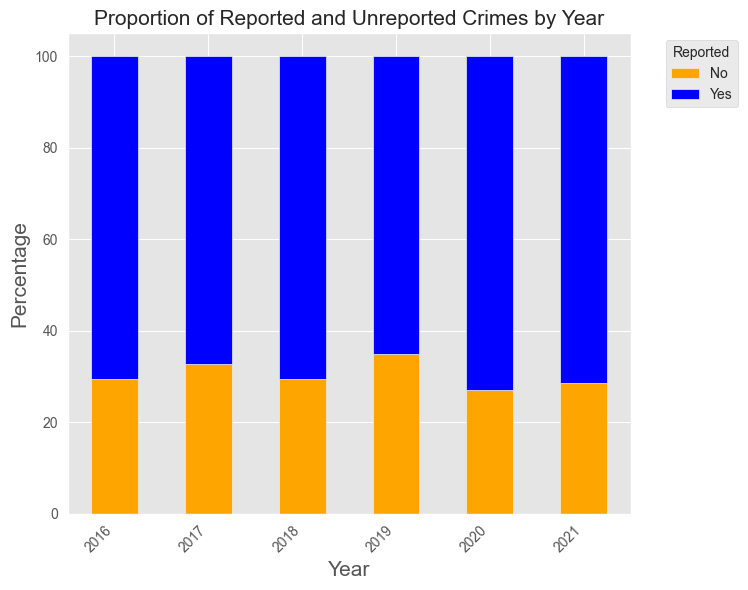

In [38]:
# Group and normalize the data
df_1621 = df_1521[(df_1521['Year'] > 2015) & (df_1521['Year'] < 2022)]
grouped = df_1621.groupby(['Year', 'Reported']).size().unstack(fill_value=0)
grouped = grouped.div(grouped.sum(axis=1), axis=0) * 100
plt.style.use('ggplot')
# Plot the data
fig, ax = plt.subplots(1, 1, figsize=(9, 6))
grouped.plot(kind='bar', stacked=True, ax=ax, color=['orange', 'blue'])

# Set the title and labels
ax.set_title('Proportion of Reported and Unreported Crimes by Year', fontsize=15)
ax.set_xlabel('Year', fontsize=15)
ax.set_ylabel('Percentage', fontsize=15)
ax.set_xticks(ax.get_xticks(), grouped.index, rotation=45, ha='right')

# Add a legend
ax.legend(title='Reported', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 0.85, 1])

# Display the plot
# plt.savefig('byyear.png', transparent = True)
plt.show()


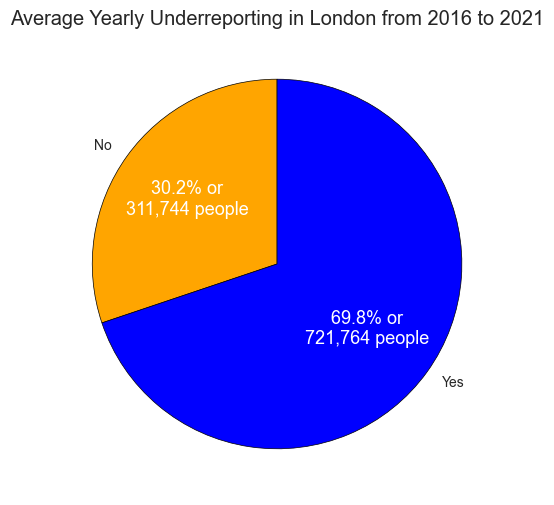

In [39]:
fig, ax = plt.subplots(figsize=(9, 6), sharey=True)
plt.style.use('ggplot')
df_1621 = df_1521[(df_1521['Year'] > 2015) & (df_1521['Year'] < 2022)]
years = df_1621['Year'].unique()
london_population = 8632850
were_a_victim = PAS_detailed[PAS_detailed['BQ90A'].isin(['Yes', 'No'])]

were_a_victim = london_population*(were_a_victim.groupby('BQ90A').size()['Yes']/were_a_victim.groupby('BQ90A').size().sum()
)

grouped = df_1621.groupby(['Reported']).size()
percentages  = grouped.div(grouped.sum(), axis=0) * 100
pop_weighted_values = (percentages / 100) * were_a_victim
wedges, texts, autotexts = ax.pie(
        pop_weighted_values, labels=pop_weighted_values.index, autopct=lambda p: f'{p:.1f}% or\n{int(p * were_a_victim / 100):,} people',
        startangle=90, wedgeprops={'edgecolor': 'black'}, colors=['orange', 'blue']
    )
# grouped.plot(kind='pie', ax=ax, autopct='%1.1f%%', startangle=90, colormap='viridis', legend=False)
# ax.set_title(f'Stacked Bar Chart by Reported and {demographic}')
ax.set_title(f'Average Yearly Underreporting in London from 2016 to 2021')
ax.set_ylabel('')
# plt.xticks(rotation=0)
# ax.legend(title=demographic)
for text in autotexts:
        text.set_color('white')
        text.set_fontsize(13)
# plt.savefig('graph2.png', transparent=True)

plt.show()

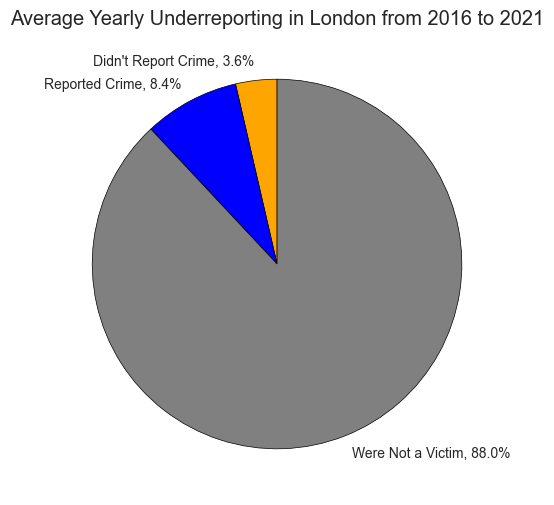

In [40]:
fig, ax = plt.subplots(figsize=(9, 6), sharey=True)
plt.style.use('ggplot')
df_1621 = df_1521[(df_1521['Year'] > 2015) & (df_1521['Year'] < 2022)]
years = df_1621['Year'].unique()
london_population = 8632850
were_a_victim = PAS_detailed[PAS_detailed['BQ90A'].isin(['Yes', 'No'])]

were_a_victim = london_population*(were_a_victim.groupby('BQ90A').size()['Yes']/were_a_victim.groupby('BQ90A').size().sum()
)

grouped = df_1621.groupby(['Reported']).size()
percentages  = grouped.div(grouped.sum(), axis=0) * 100
pop_weighted_values = (percentages / 100) * were_a_victim
pop_weighted_values['Were Not a Victim'] = london_population - were_a_victim

pop_weighted_values['Reported Crime'] = pop_weighted_values['Yes']
pop_weighted_values["Didn't Report Crime"] = pop_weighted_values['No']
pop_weighted_values = pop_weighted_values[["Didn't Report Crime", "Reported Crime", "Were Not a Victim"]]
wedges, texts= ax.pie(
        pop_weighted_values, labels=[f'{ind}, {pop_weighted_values[ind]/pop_weighted_values.sum()*100:.1f}%' for ind in pop_weighted_values.index],
        startangle=90, wedgeprops={'edgecolor': 'black'}, colors=['orange', 'blue', 'grey']
    )
# grouped.plot(kind='pie', ax=ax, autopct='%1.1f%%', startangle=90, colormap='viridis', legend=False)
# ax.set_title(f'Stacked Bar Chart by Reported and {demographic}')
ax.set_title(f'Average Yearly Underreporting in London from 2016 to 2021')
ax.set_ylabel('')
# plt.xticks(rotation=0)
# ax.legend(title=demographic)
# for text in autotexts:
#         text.set_color('white')
#         text.set_fontsize(13)
# plt.savefig('graph1.png', transparent=True)
plt.show()

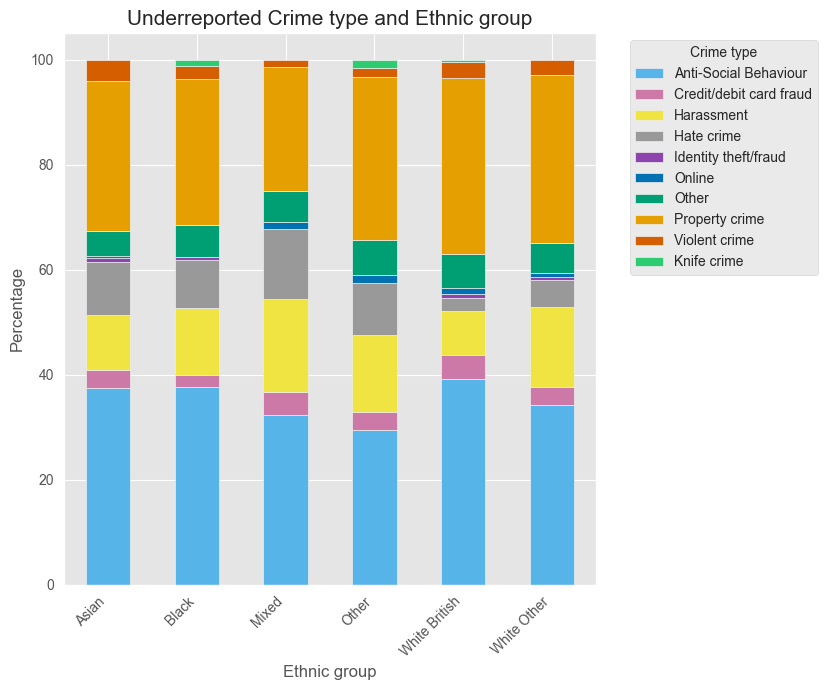

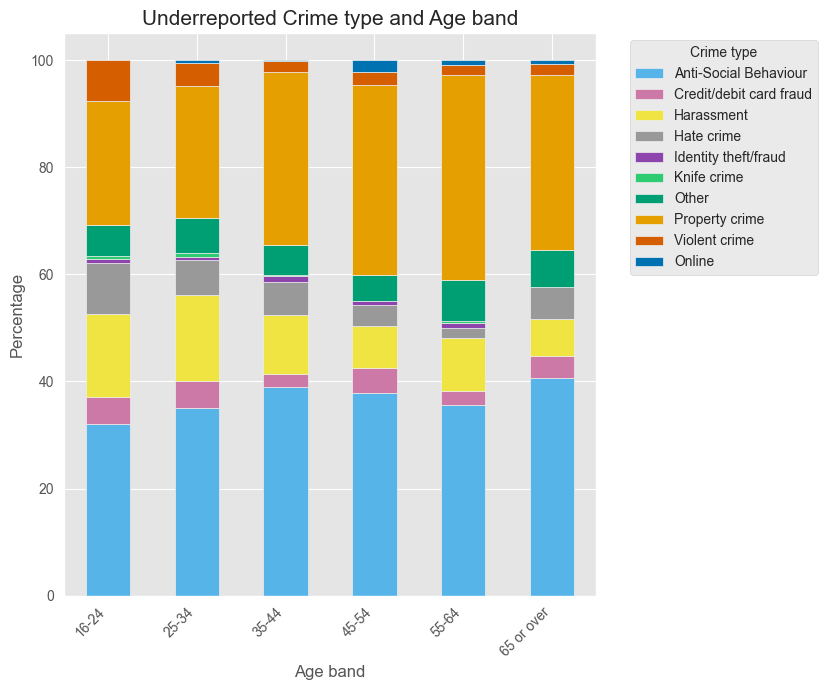

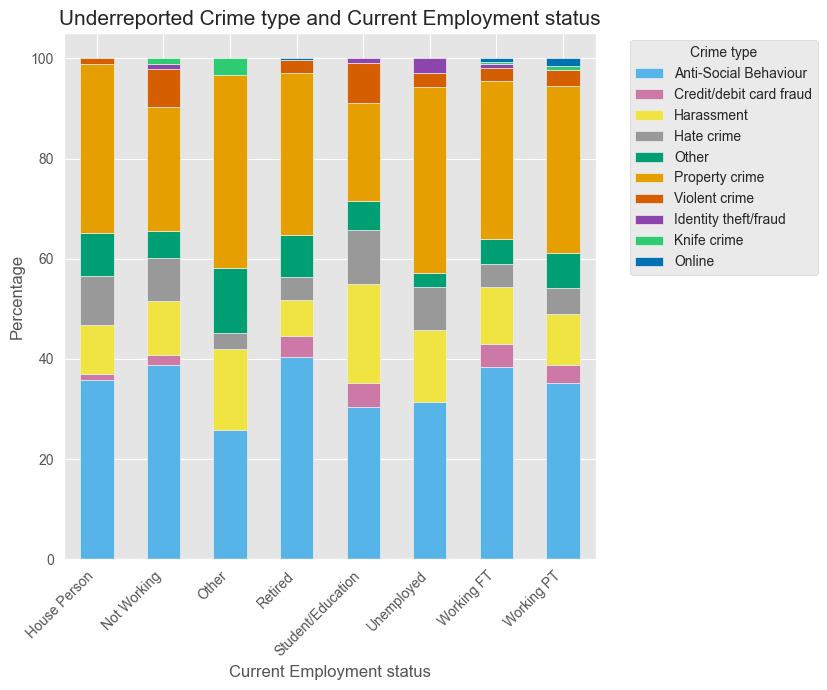

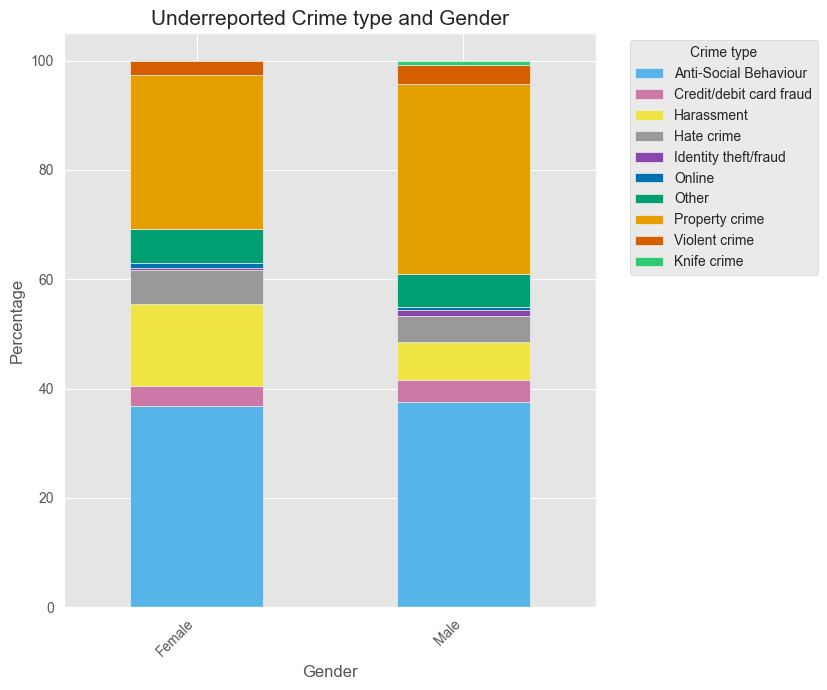

In [41]:
colors = {
    'Property crime': '#E69F00',        # Orange
    'Anti-Social Behaviour': '#56B4E9', # Sky Blue
    'Other': '#009E73',                 # Green
    'Harassment': '#F0E442',            # Yellow
    'Online': '#0072B2',                # Blue
    'Violent crime': '#D55E00',         # Vermilion
    'Credit/debit card fraud': '#CC79A7', # Reddish Purple
    'Hate crime': '#999999',            # Gray
    'Identity theft/fraud': '#8E44AD',  # Purple
    'Knife crime': '#2ECC71',           # Emerald
    'Identity theft': '#FF6347'         # Tomato
}
# were_a_victim = PAS_detailed[PAS_detailed['BQ90A'].isin(['Yes'])]

# Filter the DataFrame for the years 2016 to 2021
df_1621 = df_1521[(df_1521['Year'] > 2015) & (df_1521['Year'] < 2022)].copy()

# Standardize the 'Crime type' column
df_1621['Crime type'] = df_1621['Crime type'].replace({
    'Online contact that has caused fear, alarm or distress': 'Online',
    'Knife crime - being threatened with a knife or attacked with a knife': 'Knife crime',
    'Credit/debit card fraud': 'Credit/debit card fraud'
})

# Iterate over demographic columns and plot each on a different figure
for i, demographic in enumerate(demographic_columns):
    demographic_df = PAS_detailed.groupby(demographic).size()
    grouped = df_1621[df_1621['Reported'] == 'No'].groupby([demographic, 'Crime type']).size().unstack(fill_value=0)
    grouped = grouped.div(grouped.sum(axis=1), axis=0) * 100

    # Create a new figure for each demographic
    fig, ax = plt.subplots(figsize=(10, 7))
    grouped.plot(kind='bar', stacked=True, ax=ax, color=[colors[col] for col in grouped.columns])

    ax.set_title(f'Underreported Crime type and {demographic}', fontsize=15)
    ax.set_xlabel(demographic)
    ax.set_ylabel('Percentage')
    ax.set_xticks(ax.get_xticks(), grouped.index, rotation=45, ha='right')

    # Add the legend
    ax.legend(title='Crime type', bbox_to_anchor=(1.05, 1), loc='upper left')
    # ax.set_ylim([0,12])
    # Adjust layout to prevent overlap
    plt.tight_layout(rect=[0, 0, 0.85, 1])

    # Show the plot
    # plt.savefig(f"demographicstacked{i}.png", transparent=True)
    plt.show()

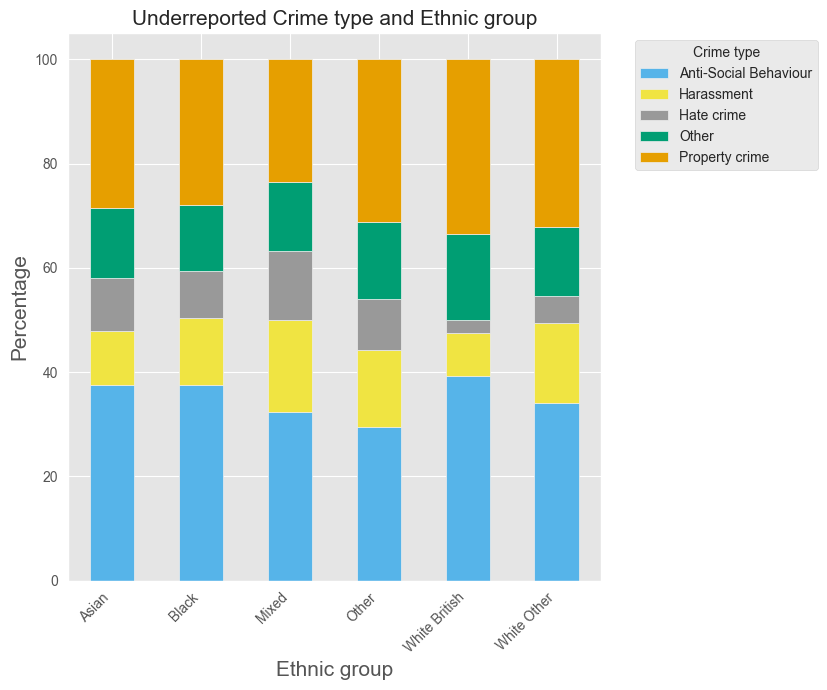

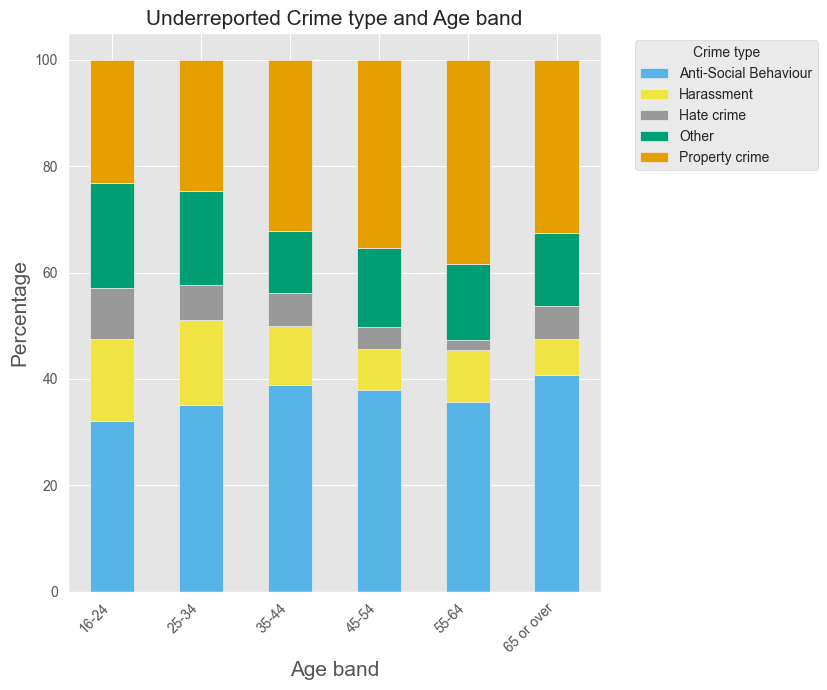

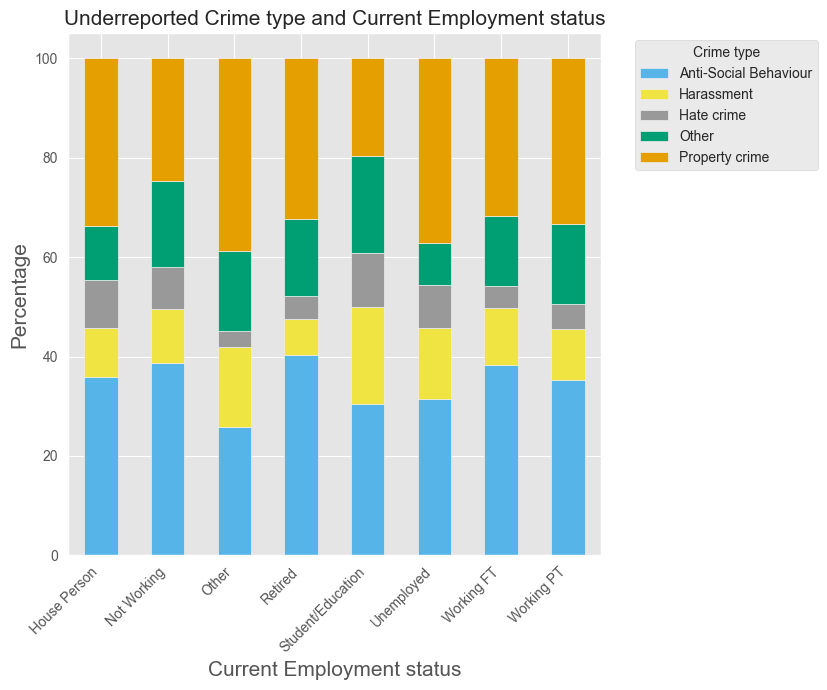

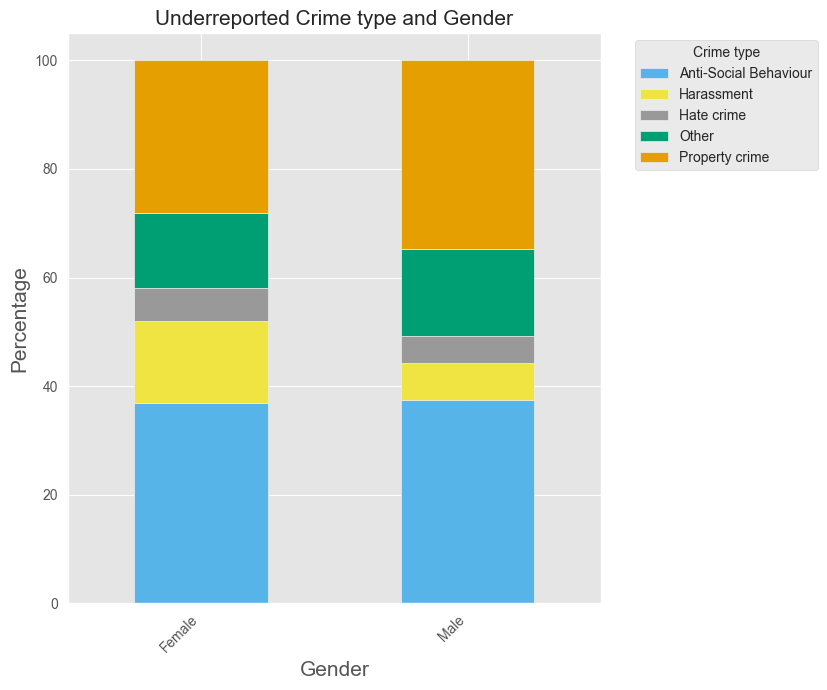

In [42]:
colors = {
    'Property crime': '#E69F00',        # Orange
    'Anti-Social Behaviour': '#56B4E9', # Sky Blue
    'Other': '#009E73',                 # Green
    'Harassment': '#F0E442',            # Yellow
    'Online': '#0072B2',                # Blue
    'Violent crime': '#D55E00',         # Vermilion
    'Credit/debit card fraud': '#CC79A7', # Reddish Purple
    'Hate crime': '#999999',            # Gray
    'Identity theft/fraud': '#8E44AD',  # Purple
    'Knife crime': '#2ECC71',           # Emerald
    'Identity theft': '#FF6347'         # Tomato
}
# were_a_victim = PAS_detailed[PAS_detailed['BQ90A'].isin(['Yes'])]

# Filter the DataFrame for the years 2016 to 2021
df_1621 = df_1521[(df_1521['Year'] > 2015) & (df_1521['Year'] < 2022)].copy()

# Standardize the 'Crime type' column
df_1621['Crime type'] = df_1621['Crime type'].replace({
    'Online contact that has caused fear, alarm or distress': 'Online',
    'Knife crime - being threatened with a knife or attacked with a knife': 'Knife crime',
    'Credit/debit card fraud ': 'Credit/debit card fraud'
})


df_1621['Crime type'] = df_1621['Crime type'].replace({
    'Online': 'Other',
    'Violent crime': 'Other',
    'Credit/debit card fraud': 'Other',
    'Identity theft/fraud': 'Other',
    'Knife crime': 'Other',
    'Identity theft': 'Other'
})

# Iterate over demographic columns and plot each on a different figure
for i, demographic in enumerate(demographic_columns):
    demographic_df = PAS_detailed.groupby(demographic).size()
    grouped = df_1621[df_1621['Reported'] == 'No'].groupby([demographic, 'Crime type']).size().unstack(fill_value=0)
    grouped = grouped.div(grouped.sum(axis=1), axis=0) * 100

    # Create a new figure for each demographic
    fig, ax = plt.subplots(figsize=(10, 7))
    grouped.plot(kind='bar', stacked=True, ax=ax, color=[colors[col] for col in grouped.columns])

    ax.set_title(f'Underreported Crime type and {demographic}', fontsize=15)
    ax.set_xlabel(demographic, fontsize=15)
    ax.set_ylabel('Percentage', fontsize=15)
    ax.set_xticks(ax.get_xticks(), grouped.index, rotation=45, ha='right')

    # Add the legend
    ax.legend(title='Crime type', bbox_to_anchor=(1.05, 1), loc='upper left')
    # ax.set_ylim([0,12])
    # Adjust layout to prevent overlap
    plt.tight_layout(rect=[0, 0, 0.85, 1])

    # Show the plot
    # plt.savefig(f"demographicstacked{i}.png", transparent=True)
    plt.show()